In [21]:
from datetime import datetime
import pandas as pd
from geopy.distance import distance
import numpy as np
import random
import json

import pymongo
from pymongo import MongoClient

from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import statsmodels.api as sm

import pymongo
from pymongo import MongoClient

import matplotlib.pyplot as plt

plt.style.use("ggplot")

%matplotlib inline

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [8]:
# Load in our parameters file
with open('../parameters.json') as f:
    params = json.load(f)

# Get relevant parameters
database = params['database']
# labeled_collection = params['labeled_collection']
# chunk_collection = params['chunk_collection']
# duration_collection = params['duration_collection']
# two_chunk_collection = params['two_chunk_collection']
six_chunk_collection = params['six_chunk_collection']

# Connect to our database/collection
client = MongoClient('localhost', 27017)
db = client[database]
# trip_coll = db[labeled_collection]
# chunk_coll = db[chunk_collection]
# duration_coll = db[duration_collection]
# two_chunk_coll = db[two_chunk_collection]
six_chunk_coll = db[six_chunk_collection]

In [9]:
six_chunk_coll.find_one()

{'_id': ObjectId('5af10f573ad39ed891accff2'),
 'seconds_chnk_1': 416.0,
 'mfn_sq_chnk_1': 481636,
 'avg_speed_chnk_1': 5.7828181818181825,
 'seconds_chnk_2': 350.0,
 'mfn_sq_chnk_2': 470596,
 'avg_speed_chnk_2': 5.208333333333333,
 'seconds_chnk_3': 440.0,
 'mfn_sq_chnk_3': 462400,
 'avg_speed_chnk_3': 5.694499999999999,
 'seconds_chnk_4': 270.0,
 'mfn_sq_chnk_4': 452929,
 'avg_speed_chnk_4': 4.722200000000001,
 'seconds_chnk_5': 243.0,
 'mfn_sq_chnk_5': 446224,
 'avg_speed_chnk_5': 5.158857142857142,
 'seconds_chnk_6': 481.0,
 'mfn_sq_chnk_6': 440896,
 'avg_speed_chnk_6': 5.3473125}

In [12]:
chunk_df = pd.DataFrame(list(six_chunk_coll.find({},{'_id':0})))

chunk_df.head()

,avg_speed_chnk_1,avg_speed_chnk_2,avg_speed_chnk_3,avg_speed_chnk_4,avg_speed_chnk_5,avg_speed_chnk_6,mfn_sq_chnk_1,mfn_sq_chnk_2,mfn_sq_chnk_3,mfn_sq_chnk_4,mfn_sq_chnk_5,mfn_sq_chnk_6,seconds_chnk_1,seconds_chnk_2,seconds_chnk_3,seconds_chnk_4,seconds_chnk_5,seconds_chnk_6
0,5.782818,5.208333,5.694500,4.722200,5.158857,5.347313,481636,470596,462400,452929,446224,440896,416.0,350.0,440.0,270.0,243.0,481.0
1,4.974773,5.540111,4.678316,4.907333,4.120083,5.711080,12321,10609,9025,7396,6400,5184,450.0,424.0,480.0,352.0,410.0,576.0
2,5.145619,4.204591,5.277826,4.314800,2.800833,3.485710,729,1296,2025,2916,3721,4489,508.0,536.0,454.0,398.0,346.0,1020.0
3,6.510500,3.465524,4.514000,2.896810,2.648200,5.785130,28900,31684,35721,39204,43264,46225,464.0,640.0,540.0,524.0,404.0,540.0
4,4.621318,4.507500,4.638850,2.806895,2.991462,5.611150,96100,102400,108900,114244,121104,125316,568.0,598.0,468.0,544.0,350.0,596.0


In [15]:
y = chunk_df['seconds_chnk_3'].values
y = y.reshape(-1,1)

X = chunk_df[['seconds_chnk_2', 'mfn_sq_chnk_2']].values

In [16]:
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)
scaler_y = StandardScaler()
y_norm = scaler_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_norm, y_norm)

# Build our model
ridge_cv = RidgeCV(alphas=[5,10,20,30], cv=20)
ridge_cv.fit(X_train, y_train)

#Score our model, R-Squared
r_squared = ridge_cv.score(X_test, y_test)

#Score our model, Root Mean Squared Error
y_predict = ridge_cv.predict(X_test)
rmse_norm = (mean_squared_error(y_test, y_predict))**.5
rmse_dev = scaler_y.inverse_transform([rmse_norm])
diff = rmse_dev[0] - scaler_y.mean_[0]

print ("R-squared: ", "{0:.2f}".format(r_squared))
print ('RMSE: ', "{0:.2f}".format(diff))

R-squared:  0.14
RMSE:  66.54


In [17]:
chunk_df['seconds_chnk_3'].mean()

447.0887605042017

In [20]:
regr = RandomForestRegressor(n_estimators=50, max_depth=2)

crossed = cross_validate(regr, X_train, y_train.flatten(), cv=20, 
                         scoring=['neg_mean_squared_error','r2'], return_train_score=False)

r_squared = crossed['test_neg_mean_squared_error'].mean()

#Score our model, Root Mean Squared Error
rmse_norm = (abs(crossed['test_neg_mean_squared_error'].mean()))**.5
rmse_dev = scaler_y.inverse_transform([rmse_norm])
diff = rmse_dev[0] - scaler_y.mean_[0]

print ("R-squared: ", "{0:.2f}".format(r_squared))
print ('RMSE: ', "{0:.2f}".format(diff))

R-squared:  -0.84
RMSE:  67.59


In [24]:
regr.fit(X_train, y_train)

regr.feature_importances_

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


array([0.38841085, 0.61158915])

In [22]:
# fit with statsmodels
model1 = sm.OLS(y_train,X_train)
results = model1.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.147
Model:                            OLS   Adj. R-squared:                  0.146
Method:                 Least Squares   F-statistic:                     122.7
Date:                Tue, 08 May 2018   Prob (F-statistic):           6.87e-50
Time:                        09:01:35   Log-Likelihood:                -1928.8
No. Observations:                1428   AIC:                             3862.
Df Residuals:                    1426   BIC:                             3872.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2972      0.027     10.843      0.000       0.243       0.351
x2            -0.1709      0.027     -6.340      0.000      -0.224      -0.118
==============================================================================
Omnibus:                      644.044   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12621.654
Skew:                           1.613   Prob(JB):                         0.00
Kurtosis:                      17.203   Cond. No.                         1.49
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
mask = (chunk_df['seconds_chnk_2'] < 1000) & (chunk_df['seconds_chnk_3'] < 1000)
trimed_chnk_df = chunk_df[mask]

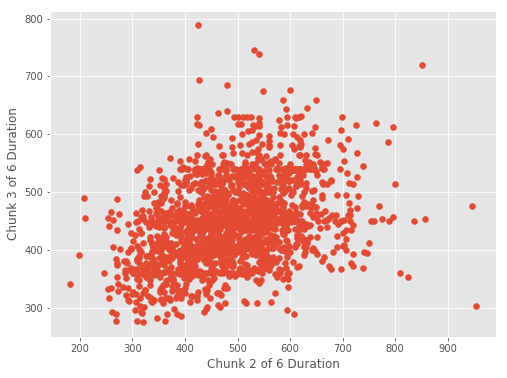

In [33]:
x = trimed_chnk_df['seconds_chnk_2'].values
y = trimed_chnk_df['seconds_chnk_3'].values
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(x, y)
ax.set_xlabel("Chunk 2 of 6 Duration")
ax.set_ylabel("Chunk 3 of 6 Duration")
plt.savefig('chunk_6_prior.jpg');

In [30]:
six_cnk_info = chnk_coll.find_one({'number_chunks':6})

In [11]:
all_trips = trip_coll.distinct('trip_id_iso')
# # Testing
# all_trips = all_trips[33:34]

In [5]:
trip_list = []

for idx, trip in enumerate(all_trips):

    print ("Getting Two-Chunk data for ", trip)
    print ("Number ", idx+1, " of ", len(all_trips))
    
    trip_data = {}
    
    breakin = 0
    
    for chnk_seq, chnk_data in six_cnk_info['chunks'].items():
        
        if chnk_seq in ['1','2', '3']:
        
            search = {
                'trip_id_iso': trip,
                'chunk_6': chnk_seq
            }

            chnk_str = '_chnk_' + chnk_seq

            chnk_cursor = trip_coll.find(search)
            
            if chnk_cursor.count() == 0:
                continue

            chnk_df = pd.DataFrame(list(chnk_cursor))

            min_ts = chnk_df['time_stamp'].min()
            max_ts = chnk_df['time_stamp'].max()
            chnk_secs = max_ts - min_ts
            
            if chnk_secs > 2500:
                breakin += 1
                break

            trip_data['seconds' + chnk_str ] = chnk_secs

            min_dt = datetime.fromtimestamp(min_ts)
            mfn_sq = (((min_dt.hour * 60) + min_dt.minute) - 720)**2

            mfn_abs = abs(((min_dt.hour * 60) + min_dt.minute) - 720)
        
            trip_data['mfn_sq' + chnk_str] = mfn_sq
            trip_data['mfn_abs' + chnk_str] = mfn_abs
            
            avg_spd = chnk_df['SPEED'].astype('float').mean()

            trip_data['avg_speed' + chnk_str] = avg_spd
        
    
    if breakin == 0:
    
        trip_list.append(trip_data)

NameError: name 'all_trips' is not defined

In [38]:
chnky_df = pd.DataFrame(trip_list)

In [52]:
chnky_df = chnky_df.dropna()

In [54]:
chnky_df.mean()

avg_speed_chnk_1             5.212797
avg_speed_chnk_2             5.333654
avg_speed_chnk_3             5.676692
chnk1_mfn_abs_chnk_1       292.667925
chnk1_mfn_abs_chnk_2       294.511698
chnk1_mfn_abs_chnk_3       296.801509
chnk1_mfn_sq_chnk_1     124639.798491
chnk1_mfn_sq_chnk_2     126523.470189
chnk1_mfn_sq_chnk_3     128583.806792
seconds_chnk_1             499.183396
seconds_chnk_2             467.242264
seconds_chnk_3             443.842264
dtype: float64

In [55]:
y = chnky_df['seconds_chnk_3'].values
y = y.reshape(-1,1)

In [60]:
# X = chnky_df[['chnk1_mfn_sq_chnk_1', 'seconds_chnk_1']].values

X = chnky_df[['seconds_chnk_2', 'chnk1_mfn_abs_chnk_2']].values
# X = X.reshape(-1,1)


In [61]:
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

scaler_y = StandardScaler()
y_norm = scaler_y.fit_transform(y)

# X_train, X_test, y_train, y_test = train_test_split(X_norm, y_norm)

# X_norm = X
# y_norm = y

X_train, X_test, y_train, y_test = train_test_split(X_norm, y_norm)

In [62]:
# fit with statsmodels
model1 = sm.OLS(y_train,X_train)
results = model1.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     52.23
Date:                Fri, 04 May 2018   Prob (F-statistic):           2.72e-22
Time:                        13:24:04   Log-Likelihood:                -1375.8
No. Observations:                 993   AIC:                             2756.
Df Residuals:                     991   BIC:                             2765.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2134      0.033      6.533      0.000       0.149       0.277
x2            -0.1698      0.033     -5.164      0.000      -0.234      -0.105
==============================================================================
Omnibus:                      388.122   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7871.391
Skew:                           1.278   Prob(JB):                         0.00
Kurtosis:                      16.554   Cond. No.                         1.43
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [63]:
regr = RandomForestRegressor(n_estimators=50)

crossed = cross_validate(regr, X_norm, y_norm.flatten(), cv=20, 
                         scoring=['neg_mean_squared_error','r2'], return_train_score=False)

rmse_norm = (abs(crossed['test_neg_mean_squared_error'].mean()))**.5
r2 = crossed['test_neg_mean_squared_error'].mean()

print ("R-squared: ", r2)
print ('RMSE: ', scaler_y.inverse_transform([rmse_norm])[0])

R-squared:  -0.9742037246446124
RMSE:  530.5401597908635


In [64]:
x = chnky_df['seconds_chnk_3'].values
y = chnky_df['seconds_chnk_2'].values

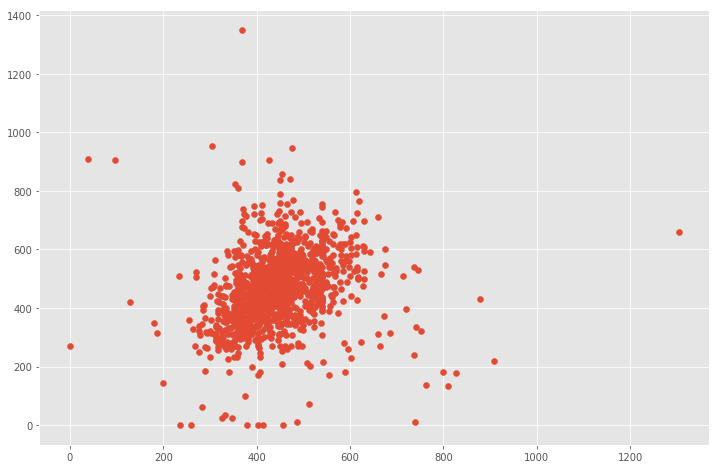

In [65]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(x, y);